In [7]:
import torch
import matplotlib.pyplot as plt

from m2_utilities.load_data import load_trajectories
from m2_utilities.preprocessor import tokenize, detokenize
from m2_utilities.qwen import load_qwen

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the Model and Data

In [37]:
# Model
model, tokenizer = load_qwen()

In [55]:
# Data
unscaled_trajectories = load_trajectories("data/lotka_volterra_data.h5")

# Scaling
ALPHA = 1.5
trajectories = unscaled_trajectories / ALPHA

### Testing an Input

In [64]:
trunc_trajectories = trajectories[:, :50, :]
token_trajectories = tokenize(trunc_trajectories, decimals=2)

In [81]:
single_system = token_trajectories[0]

single_system = single_system.reshape(1, -1)

torch.Size([1, 499])

In [90]:
output = model.generate(single_system, max_new_tokens=100, do_sample=False)

tensor([[15, 13, 21, 18, 11, 15, 13, 21, 24, 26, 15, 13, 19, 24, 11, 15, 13, 20,
         17, 26, 15, 13, 19, 20, 11, 15, 13, 18, 23, 26, 15, 13, 19, 23, 11, 15,
         13, 17, 22, 26, 15, 13, 20, 20, 11, 15, 13, 17, 15, 26, 15, 13, 21, 22,
         11, 15, 13, 16, 20, 26, 15, 13, 23, 19, 11, 15, 13, 16, 17, 26, 16, 13,
         15, 22, 11, 15, 13, 16, 16, 26, 16, 13, 18, 20, 11, 15, 13, 16, 15, 26,
         16, 13, 21, 23, 11, 15, 13, 16, 16, 26, 17, 13, 15, 18, 11, 15, 13, 16,
         17, 26, 17, 13, 18, 20, 11, 15, 13, 16, 21, 26, 17, 13, 20, 23, 11, 15,
         13, 17, 16, 26, 17, 13, 21, 20, 11, 15, 13, 18, 15, 26, 17, 13, 20, 17,
         11, 15, 13, 19, 17, 26, 17, 13, 16, 22, 11, 15, 13, 20, 20, 26, 16, 13,
         22, 15, 11, 15, 13, 21, 20, 26, 16, 13, 17, 21, 11, 15, 13, 21, 23, 26,
         15, 13, 24, 19, 11, 15, 13, 21, 17, 26, 15, 13, 22, 21, 11, 15, 13, 20,
         17, 26, 15, 13, 21, 24, 11, 15, 13, 19, 16, 26, 15, 13, 21, 24, 11, 15,
         13, 18, 18, 26, 15,

In [91]:
prediction = detokenize(output)

torch.Size([1, 60, 2])


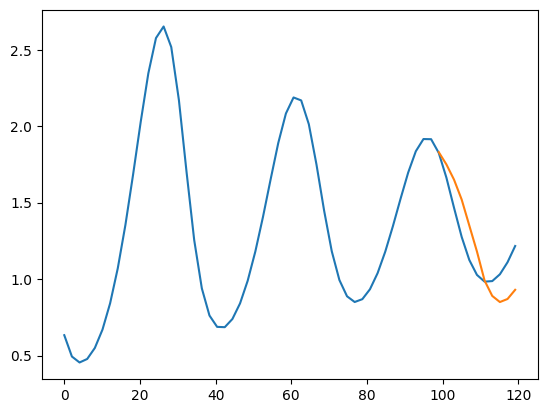

In [109]:
times = torch.linspace(0, 200, 100)[:prediction.shape[1]]
plt.plot(times, trajectories[0, :prediction.shape[1], 0])
plt.plot(times[49:], prediction[0, 49:, 0])
plt.show()